#  CH4 over Riyadh, Saudi Arabia from Sentinel 5P

To explore other bands in Sentinel-5P data, you can modify the bands parameter in the load_collection function. Sentinel-5P provides several other bands, such as:

CO (Carbon Monoxide), SO2 (Sulfur Dioxide), O3 (Ozone), CH4 (Methane), HCHO (Formaldehyde), AER_AI (Aerosol Index).

This notebook is inspired by the script developed by the Sentinel-5P here on this link: https://documentation.dataspace.copernicus.eu/Data/SentinelMissions/Sentinel5P.html 

Tips: study the bands that the Sentinel-5P is tuned to

Authenticated using refresh token.
0:00:00 Job 'j-241006b23de94f64b55656c94cb9cd4c': send 'start'
0:00:12 Job 'j-241006b23de94f64b55656c94cb9cd4c': created (progress 0%)
0:00:18 Job 'j-241006b23de94f64b55656c94cb9cd4c': created (progress 0%)
0:00:24 Job 'j-241006b23de94f64b55656c94cb9cd4c': created (progress 0%)
0:00:32 Job 'j-241006b23de94f64b55656c94cb9cd4c': created (progress 0%)
0:00:42 Job 'j-241006b23de94f64b55656c94cb9cd4c': created (progress 0%)
0:00:55 Job 'j-241006b23de94f64b55656c94cb9cd4c': running (progress N/A)
0:01:10 Job 'j-241006b23de94f64b55656c94cb9cd4c': running (progress N/A)
0:01:30 Job 'j-241006b23de94f64b55656c94cb9cd4c': running (progress N/A)
0:01:54 Job 'j-241006b23de94f64b55656c94cb9cd4c': running (progress N/A)
0:02:28 Job 'j-241006b23de94f64b55656c94cb9cd4c': running (progress N/A)
0:03:06 Job 'j-241006b23de94f64b55656c94cb9cd4c': running (progress N/A)
0:03:53 Job 'j-241006b23de94f64b55656c94cb9cd4c': running (progress N/A)
0:04:51 Job 'j-241006b23de94f64

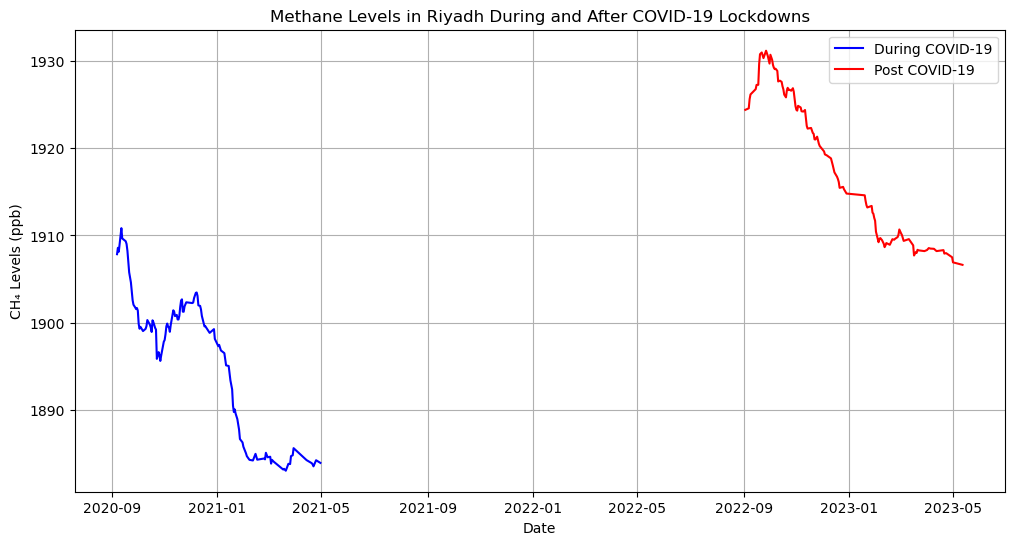

In [3]:

import openeo
import xarray as xr
import matplotlib.pyplot as plt

# Connect to the OpenEO backend and authenticate
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

# Define the area of interest (AOI) over Riyadh (we can change this to any city in Saudi Arabia or even include the whole Arabian Peninsula). 
riyadh_aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [46.55, 24.85],
            [46.55, 24.50],
            [46.95, 24.50],
            [46.95, 24.85],
            [46.55, 24.85],
        ]
    ],
}

# Define time periods for during and after COVID-19 lockdowns
during_covid_period = ["2020-06-01", "2021-06-30"]
post_covid_period = ["2022-06-01", "2023-06-30"]

# Load Sentinel-5P CH₄ data during COVID-19 lockdown
ch4_during_covid = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent={"west": 46.55, "south": 24.50, "east": 46.95, "north": 24.85},
    temporal_extent=during_covid_period,
    bands=["CH4"],
)

# Aggregate data by day to obtain daily averages
ch4_during_daily = ch4_during_covid.aggregate_temporal_period(period="day", reducer="mean")

# Perform spatial aggregation over the AOI
ch4_during_mean = ch4_during_daily.aggregate_spatial(riyadh_aoi, reducer="mean")

# Repeat the process for the post-COVID-19 period
ch4_post_covid = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent={"west": 46.55, "south": 24.50, "east": 46.95, "north": 24.85},
    temporal_extent=post_covid_period,
    bands=["CH4"],
)

ch4_post_daily = ch4_post_covid.aggregate_temporal_period(period="day", reducer="mean")
ch4_post_mean = ch4_post_daily.aggregate_spatial(riyadh_aoi, reducer="mean")

# Execute batch jobs to retrieve the data
job_during = ch4_during_mean.execute_batch(
    outputfile="riyadh_ch4_during_covid.nc", title="Riyadh CH4 During COVID-19"
)

job_post = ch4_post_mean.execute_batch(
    outputfile="riyadh_ch4_post_covid.nc", title="Riyadh CH4 Post COVID-19"
)

# Load the NetCDF files into xarray datasets
data_during = xr.load_dataset("riyadh_ch4_during_covid.nc")
data_post = xr.load_dataset("riyadh_ch4_post_covid.nc")

# Apply a 30-day rolling mean to smooth the data
data_during_smoothed = data_during.rolling(t=30, center=True).mean()
data_post_smoothed = data_post.rolling(t=30, center=True).mean()

# Plot the methane levels during and after the lockdown
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(
    data_during_smoothed.t,
    data_during_smoothed.CH4.values.flatten(),
    label="During COVID-19",
    color="blue",
)
plt.plot(
    data_post_smoothed.t,
    data_post_smoothed.CH4.values.flatten(),
    label="Post COVID-19",
    color="red",
)
plt.xlabel("Date")
plt.ylabel("CH₄ Levels (ppb)")
plt.title("Methane Levels in Riyadh During and After COVID-19 Lockdowns")
plt.legend()
plt.grid(True)
plt.show()
